In [1]:
import lettuce as lt
import matplotlib.pyplot as plt

import warnings
import numpy as np
from lettuce.unit import UnitConversion
from lettuce.util import append_axes
from lettuce.boundary import EquilibriumBoundaryPU, BounceBackBoundary, EquilibriumOutletP, AntiBounceBackOutlet

import torch
import time

In [2]:
### Parameter
re = 100
n_steps = 50000
ny = 100 #ny=2*nx
u_init = 1 #1= kein Geschwindigkeit, 2=poiseuille-artig
perturb_init = False # leichte Asymmetrie in Anfangs-Geschwindigkeitsverteilung -> Amplitude kann unten gewählt werden
u_in_parabel = True # True=parabel_in, False=constant_in
bb_wall = True # True= bounce-back-walls, False= periodic RB-walls
cylinder = True # True = cylinder obstacle, False = no obstascle
vtk_out = True # True = vtk-output, False = no vtk-output
vtk_interval=50

In [3]:
### Cylinder2D: modifizierte obstacle.py Klasse, zur Simulation eines umströmten Zylinders

class Cylinder2D:

    def __init__(self, shape, reynolds_number, mach_number, lattice, domain_length_x, char_length=1, char_velocity=1, boundary=None):
        if len(shape) != lattice.D:
            raise ValueError(f"{lattice.D}-dimensional lattice requires {lattice.D}-dimensional `shape`")
        self.shape = shape
        char_length_lu = shape[0] / domain_length_x * char_length
        self.units = UnitConversion(
            lattice,
            reynolds_number=reynolds_number, mach_number=mach_number,
            characteristic_length_lu=char_length_lu, characteristic_length_pu=char_length,
            characteristic_velocity_pu=char_velocity
        )
        self._mask = np.zeros(shape=self.shape, dtype=bool) #deprecation warning: "np.bool" ist ein alter alias für das buildin "bool"
        self._boundary = boundary

    @property
    def mask(self):
        return self._mask

    @mask.setter
    def mask(self, m):
        assert isinstance(m, np.ndarray) and m.shape == self.shape
        self._mask = m.astype(bool) #deprecation warning: "np.bool" ist ein alter alias für das buildin "bool"

    def initial_solution(self, x):
        p = np.zeros_like(x[0], dtype=float)[None, ...]
        u_char = self.units.characteristic_velocity_pu * self._unit_vector()
        u_char = append_axes(u_char, self.units.lattice.D) # u_char ist in PU (!) -> 1.0
        u = (1 - self.mask) * u_char
        #print("u erste aus initial: ", u)
        
### Wähle initiale Geschwindigkeitsverteilung:
        #u_init = 0 # uniform ux=1.0
        
        if u_init == 1: # no velocity
            u = u * 0
        elif u_init ==2: # uniform parabolic (a bit like poiseuille-flow)
            ### initiale Geschwindigkeitsverteilung parabelförmig
            u = (1 - self.mask) * u_char
            ny = self.shape[1] #Gitterpunktzahl in y-Richtung           
            u1=np.zeros(ny)
            parabel_breite = ny-2
            y_werte = np.arange(0, parabel_breite) + 0.5
            u1[1:-1] = - self.units.characteristic_velocity_pu * y_werte * (y_werte - (parabel_breite)) * 1/(parabel_breite/2)**2
            print("u1 aus initial: ", u1)
            u=np.einsum('k,ijk->ijk',u1,u)
            print("u aus initial: ", u)

### Störe Initialverteilung für Asymmetrie
        if perturb_init:
            # überlagere Sinus-Störung in ux über die zweite Spalte
            ny = x[1].shape[1]
            if u.max() < 0.5*self.units.characteristic_velocity_pu:
                u[0][1] += np.sin(np.arange(0, ny) / ny * 2 * np.pi) * self.units.characteristic_velocity_pu * 1.0 #0.3
            else:
                u[0][1] *= 1 + np.sin(np.arange(0, ny) / ny * 2 * np.pi) * self.units.characteristic_velocity_pu * 0.3
            plt.plot(u[0][1])
        return p, u

    @property
    def grid(self):
        # linspace erlaubt endpoint=True im Gegensatz zu Arange "np.linspace(0,n,n)" war vorher "np.arange(n)"
        xyz = tuple(self.units.convert_length_to_pu(np.linspace(0,n,n)) for n in self.shape)
        return np.meshgrid(*xyz, indexing='ij')

    @property
    def boundaries(self):
        x = self.grid[0]
        
        # INLET mask
        inmask = np.zeros(self.grid[0].shape, dtype=bool)
        inmask[0, 1:-1] = True  # bzw. inmask [0,:] ABER DANN überlagern sich die Boundaries in den Ecken, bzw. auf jeden Ecke überlagern sich die Ränder mit den Wänden

### BB oder periodic RB auf oberem und unterem Rand    
        # BounceBack auf der oberen und unteren Wand:
        if bb_wall == True:
            self.mask[:, [0, -1]] = True

        if self._boundary is None: #falls _boundary nicht außerhalb der Klasse belegt wurde
            inlet_boundary = EquilibriumBoundaryPU(
                # np.abs(x) < 1e-6, # ursprüngliche Implementierung sucht hierrüber den Rand
                inmask, # definiert Einlass
                self.units.lattice, self.units,
                self.units.characteristic_velocity_pu * self._unit_vector()
            )
        else:
            inlet_boundary = self._boundary
        return [
            inlet_boundary,
            # AntiBounceBackOutlet(self.units.lattice, self._unit_vector().tolist()), #crasht, sobald der erste Wirbel den Auslass trifft
            EquilibriumOutletP(self.units.lattice, self._unit_vector().tolist()),  # wird von PyCharm als "unknown reference" markiert? -> LSG: stand oben im Import nicht drin (!)
            BounceBackBoundary(self.mask, self.units.lattice) #BounceBack definiert über self.mask, u.a. für das obstacle selbst (!)
        ]

    def _unit_vector(self, i=0):
        return np.eye(self.units.lattice.D)[i]

In [4]:
### Modifizierte EquilibrimuBoundary.PU aus boundary.py, welche die Möglichkeit eines parabelförmigen
### Geschwindigkeitsprofils am Einlass erlaubt.

class EquilibriumBoundaryPU:
    """Sets distributions on this boundary to equilibrium with predefined velocity and pressure.
    Note that this behavior is generally not compatible with the Navier-Stokes equations.
    This boundary condition should only be used if no better options are available.
    """

    def __init__(self, mask, lattice, units, velocity, pressure=0):
        self.mask = lattice.convert_to_tensor(mask)
        self.lattice = lattice
        self.units = units
        self.velocity = lattice.convert_to_tensor(velocity)
        self.pressure = lattice.convert_to_tensor(pressure)

    def __call__(self, f):
        rho = self.units.convert_pressure_pu_to_density_lu(self.pressure)
        
        ### räumliche Form des einströmenden Geschwindigkeitsprofils
        ### PARABEL- (später mal Poiseuille) oder KONSTANT
### Geschwindigkeitsverteilung am Einlass        
        #u_in_parabel=True
        if u_in_parabel:
            ## Parabelförmige Geschwindigkeit, vom zweiten bis vorletzten Randpunkt, damit die RB nicht mit den Wänden kollidiert
                ## How to Parabel:
                ## 1.Parabel in Nullstellenform: y = (x-x1)*(x-x2)
                ## 2.nach oben geöffnete Parabel mit Nullstelle bei x1=0 und x2=x0: y=-x*(x-x0)
                ## 3.skaliere Parabel, sodass der Scheitelpunkt immer bei ys=1.0 ist: y=-x*(x-x0)*(1/(x0/2)²)
                ## (4. optinal) skaliere Amplitude der Parabel mit 1.5, um dem Integral einer konstanten Einstromgeschwindigkeit zu entsprechen
            ny = f.shape[2] #Gitterpunktzahl in y-Richtung
            u1 = np.zeros((1,ny)) #x-Geschwindigkeiten der Randbedingung
            parabel_breite = ny-2 #lässt die Wand-Randbedingung aus, diese wird nicht belegt                
            y_werte = np.arange(0, parabel_breite) + 0.5 # die 0.5 shiftet die Parabel, sodass man Symmetrie erhält, sowohl bei geraden, als auch ungeraden Gitterpunktzahlen
            # Skalierungsfaktor 3/2=1.5 für die Parabelamplitude, falls man im Integral der Konstantgeschwindigkeit entsprechenn möchte.
            u1[:,1:-1] = - self.units.characteristic_velocity_lu * y_werte * (y_werte - (parabel_breite)) * 1/(parabel_breite/2)**2 # (!) es muss die charakteristische Geschwindigkeit in LU genutzt werden (!) -> der Unterschied PU/LU ist u.U. Größenordnungen und es kommt bei falscher Nutzung zu Schock/Überschall -> Crash
            # in 2D braucht u1 dann die Dimension 1 x ny (!)
            # u1 wird ux, u2 wird uy, beide stehen zusammen in u
            u2 = np.zeros_like(u1) #keine y-Geschwindigkeit
            u = np.stack([u1, u2], axis=0)
            u = self.lattice.convert_to_tensor(u)
            feq = self.lattice.equilibrium(rho, u) # Berechne Gleichgewichtsverteilung auf Einlassrand
            f[:,0,:]=feq[:, 0, :] # setze die FEQ mit parabelförmiger Geschwindigkeit nur auf den Einlass Rand
        else:
            ## konstante Geschwindigkeitswert (u_LU: 0.0289, u_PU: 1.0)        
            u = self.units.convert_velocity_to_lu(self.velocity) # ein Tensor: tensor([0.0289, 0.0000], device='cuda:0')
            feq = self.lattice.equilibrium(rho, u)
            feq = self.lattice.einsum("q,q->q", [feq, torch.ones_like(f)])
            #  feq = self.lattice.einsum("q,q->q", [feq, torch.ones_like(f)]) # "einsum" MÄCHTIG -> Matrix/Vektor verwurschteln. 
            # feq hat einen INdex q (hier velocities aus dem Stencil) -> kann ale Vektoroperationen vollführen, wenn man die Indizierung kennt und die an einsum() korrekt mitgibt
            # Die q-Dimension vom einen mit der q-Dimension vom anderen multipliziert, ergibt die neue q-Dimension des Ergebnisses
            # Vektorprodukt, Kreuzprodukt, Additione etc., sämtliche Vektor/Matrix/Tensor-Operationen lassen sich über Einsum abbilden
            f = torch.where(self.mask, feq, f)
        
        return f

In [5]:
### Parameter
#exmpl: Re1000,steps25000,ny1000 braucht 43min
    #re=10
    #n_steps=25000
    #ny=5 #nx=2*ny

# Inlet-Geschwindigkeitsverteilung: in EquilibriumBoundaryPU oben
# Wand-Randbindungen (BounceBack oder periodic) in boundary in Cylinder2D oben
# Störung in initial_solution in Cylinder2D oben

### Setup

lattice = lt.Lattice(lt.D2Q9, "cuda:0", dtype=torch.float64)
flow = Cylinder2D(
    (2*ny, ny), #shape der 2D-Box ist XxY: 2ny x ny
    reynolds_number=re, #50.0
    mach_number=0.05,
    lattice=lattice,
    domain_length_x=10.0 #10.1, # in PU
)

### Einlass-Randbedingung

# INLET mask wird bei "parabel" nicht verwendet (!) -> Maske ist dort direkt in der Belegung von f in der bounrady-Klasse (s.o.) definiert
inmask = np.zeros(flow.grid[0].shape, dtype=bool)
inmask[0, 1:-1] = True # Ort der EquilibriumBoundaryPU RB: konret: kompletter linker Rand, exklusive Eckpunkten
boundary = EquilibriumBoundaryPU(
    inmask,
    flow.units.lattice, flow.units,
    flow.units.characteristic_velocity_pu * flow._unit_vector()
)
flow._boundary = boundary

### Definiere Obstacle (Zylinder)
if cylinder == True:
    x, y = flow.grid #gibt ein Meshgrid zurück: x-2D-Array, y-2D-Array
        # in der ursprünglichen Implementierung von grid mit "arange(n)" reicht das grid für n=10 z.B. von 0 bis 9... d.h. die Position 5 ist nicht in der Mitte (!)
        # in Cylnider2D (s.o.) ist das grid mit linspace erstellt und geht für n Punkte von 0 bis n inklusive 0 und n als Randpunkte
    #print("x grid ", x)
    #print("y grid ", y)

    # Zylinder - Kreisgleichung (x-x0)²+(y-y0)²<r² in PU
    condition = np.sqrt((x-2.5)**2+(y-2.5)**2) < 0.5 #die Kreisgleichung rechnet in PU, d.h. die Auflösung spielt hier keine Rolle(!)
    flow.mask[np.where(condition)] = 1 #erstelle Obstacle Form (mask als Bool)

#print("flow_obstacle_mask: ",flow.mask) #kontrolliere Symmetrie

tau = flow.units.relaxation_parameter_lu
sim = lt.Simulation(flow, lattice, lt.BGKCollision(lattice, tau), 
                    lt.StandardStreaming(lattice))

### Reporter

# VTK Reporter -> Visualisierung
if vtk_out == True:
    VTKreport = lt.VTKReporter(lattice, flow, interval=vtk_interval, filename_base="/mnt/ScratchHDD1/Max_Scratch/cylinder_vtk/out")
    sim.reporters.append(VTKreport)



In [6]:
# ### Simulation

# t_start=time.time()
# #sim.step(n_steps) #Simulation mit Schrittzahl n_steps
# print("PU-Time: ",flow.units.convert_time_to_pu(n_steps)," seconds")
# print("Re=",re)
# print("char_velocity_LU", flow.units.characteristic_velocity_lu)
# print("number of steps:",n_steps)
# print("runtime: ",time.time()-t_start, "seconds")

In [7]:
# sim.step(1)
# u = lattice.u(sim.f)
# print(" u nach step:",u)

In [8]:
diff_list = []
u_list = []

In [9]:
### Simulation mit u_diff

# Wähle Koordinaten des Geschwindigkeits-Messpunkts für die u_diff Analyse (relativ zum Gitter in LU)
nx, ny = flow.shape
x_test = int(nx/2)
y_test = int(ny/4)

t_start = time.time()
for i in range(n_steps):
    sim.step(1)
    #finde Asymmetrie der Geschwindigkeit in y-Richtung um Spiegelachse:
    #Differenz zwischen ux und ux an um y gespiegelt:
    u = lattice.u(sim.f)
    u_diff = torch.flip(u,[2])-u
    u_list.append(u[0,x_test,y_test].cpu())
    diff_list.append(u_diff[0,x_test,y_test].cpu())
t_end = time.time()-t_start
print("PU-Time: ",flow.units.convert_time_to_pu(n_steps)," seconds")
print("number of steps:",n_steps)
print("runtime: ",time.time()-t_start, "seconds")

PU-Time:  72.16878364870324  seconds
number of steps: 50000
runtime:  72.01323390007019 seconds


Text(0.5, 1.0, 'u_diff @ x,y = 100,25')

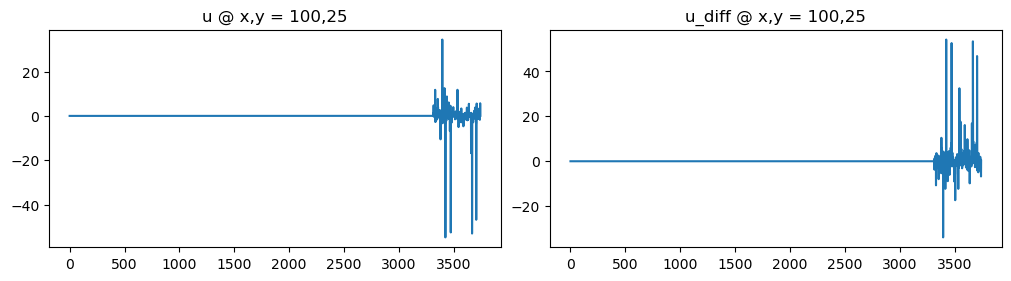

In [21]:
### plot u_diff - Symmetrieuntersuchung der Geschwindigkeit

fig, axs = plt.subplots(1, 2, figsize=(10, 2.7), layout='constrained')
axs[0].plot(u_list)
axs[0].set_title("u @ x,y = "+str(x_test)+","+str(y_test))
axs[1].plot(diff_list)
axs[1].set_title("u_diff @ x,y = "+str(x_test)+","+str(y_test))

In [11]:
### print sim parms

print("### sim parms ###")
print("Re = ", re)
print("n_steps = ", n_steps)
print("nx x ny = ", 2*ny, " x ", ny)
print("u_init = ", u_init)
print("u_in_parabel = ", u_in_parabel)
print("bb_wall = ", bb_wall)
print("cylinder = ", cylinder)
print("vtk_out = ", vtk_out)

### sim parms ###
Re =  10000
n_steps =  50000
nx x ny =  200  x  100
u_init =  1
u_in_parabel =  True
bb_wall =  True
cylinder =  True
vtk_out =  True


In [12]:
u.max

<function Tensor.max>

In [13]:
print(u.max())

tensor(nan, device='cuda:0', dtype=torch.float64)


In [14]:
print(u.min())

tensor(nan, device='cuda:0', dtype=torch.float64)
